Работу выполнил Данил Исламов (Stepik ID: 274397404)

# Homework, part 1. GPT

In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 4.5MB/s 
     |████████████████████████████████| 225kB 22.2MB/s 
     |████████████████████████████████| 3.3MB 21.5MB/s 
     |████████████████████████████████| 901kB 38.1MB/s 
     |████████████████████████████████| 245kB 40.6MB/s 
     |████████████████████████████████| 112kB 43.9MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделями трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищены от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

In [ ]:
# Посмотрим, какие классы есть в датасете
set(emotion_dataset["train"]["label"])

{0, 1, 2, 3, 4, 5}

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=self.max_length,
                                                      padding='max_length', return_tensors='pt')
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(), 
            "mask": tokenizer_output['attention_mask'].squeeze(),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation')
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 32 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
data = next(iter(train_loader))
tokens = data['input_ids'].to(device) # Получи токены из датасета
mask = data['mask'].to(device) # Получи маску из датасета

model_0(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут

SequenceClassifierOutputWithPast([('logits',
                                   tensor([[ 0.2629, -0.6642,  0.4545,  0.9217,  0.5519,  1.1382],
                                           [-0.1544, -0.4889, -0.0171,  1.1637,  0.3323,  0.9044],
                                           [-0.4088,  0.1622,  0.2236,  0.5596, -0.3674, -0.3021],
                                           [-0.8445,  0.0663,  0.2059, -0.4476,  0.5514,  0.1665],
                                           [ 0.0327, -0.0808, -0.7153,  1.2367, -0.2941,  1.2406],
                                           [-0.2166,  0.2630, -0.5508,  0.4886,  0.2182,  1.3568],
                                           [-0.2321,  0.1805, -0.4834, -0.0341,  0.4542,  0.5030],
                                           [ 0.8858,  0.0948,  0.2375,  1.3019,  0.4630,  0.5569],
                                           [-0.9184, -0.0986,  0.1639,  0.1872,  0.2942, -0.0317],
                                           [-0.8079, -0.3859,  0

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

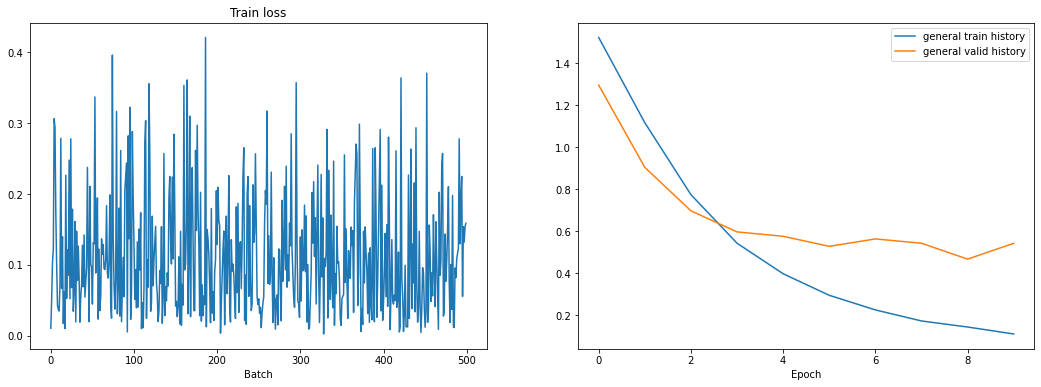

Train Loss: 0.11194479978037998,Valid Loss: 0.5430543481534909,Valid Acc: 0.8616071939468384
Test Acc: 0.8333333730697632


In [ ]:
from tqdm.notebook import tqdm

best_valid_loss = float('inf')

num_epochs = 10
train_history = []
valid_history = []

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    history = []
    for batch in tqdm(train_loader):

        optimizer.zero_grad()

        tokens = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        outp = model_0(input_ids=tokens, attention_mask=mask).logits

        loss = criterion(outp, target)
        train_loss += loss.item()
        history.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), 1)
        optimizer.step()

    train_history.append(train_loss / len(train_loader))  

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            tokens = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            target = batch['target'].to(device)

            outp = model_0(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(outp, target)
            valid_loss += loss.item()

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model_0.state_dict(), 'best-val-model_0.pt')

            valid_acc += torch.sum(torch.argmax(outp, dim=-1) == target) / len(target)
            
    valid_history.append(valid_loss / len(valid_loader))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
 
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')

    ax[1].plot(train_history, label='general train history')        
    ax[1].plot(valid_history, label='general valid history')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.show()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.load_state_dict(torch.load('best-val-model_0.pt'))
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        
        tokens = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        outp = model_0(input_ids=tokens, attention_mask=mask).logits

        test_acc += torch.sum(torch.argmax(outp, dim=-1) == target) / len(target)

print(f"Test Acc: {test_acc / len(test_loader)}")

Заметно, что модель начала переобучаться после второй эпохи, однако лосс на валидационной части всё же продолжал медленно падать. В любом случае, лучшая модель определялась по величине валидационного лосса, так что, если модель и была переобучена, эффект этот не был слишком явным.

In [ ]:
model_0.load_state_dict(torch.load('best-val-model_0.pt'))

<All keys matched successfully>

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))

    return np.array(attn)

In [ ]:
# shows attention of the certain head of certain layer (with details)

def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
# shows all attention maps (for general understanding)

def show_all_attentions(seq, attentions):
    num_layers = attentions.shape[0]
    num_heads = attentions.shape[1]
    
    # Set up figure with colorbar
    fig, ax = plt.subplots(nrows=num_layers, ncols=num_heads, figsize=(40, 20))

    for i in range(num_layers):
        for j in range(num_heads):
            cax = ax[i][j].matshow(attentions[i][j])            
            
            # Set up axes
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])
            if i == num_layers - 1:
                ax[i][j].set_xlabel(j+1, fontsize=40)
            if j == 0:
                ax[i][j].set_ylabel(f'{i+1} ', rotation='horizontal', fontsize=40)

    fig.suptitle('Attentions', fontsize=80)
    fig.text(0.5, 0.04, 'Head', ha='center', fontsize=60)
    fig.text(0.08, 0.5, 'Layer', va='center', rotation='vertical', fontsize=60)
    plt.show()

Возьмём 100-е предложение тренировочной части датасета в качестве примера, т.к. оно достаточно длинное и сложное по структуре — возможно, удастся заметить какие-то интересные закономерности во внимании.

In [ ]:
text = emotion_dataset['train']['text'][100] # Выбери текст из датасета
print(emotion_dataset['train']['text'][100])
tokens = tokenizer.tokenize(text)
tokens = [x.lstrip('Ġ') for x in tokens]

i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months


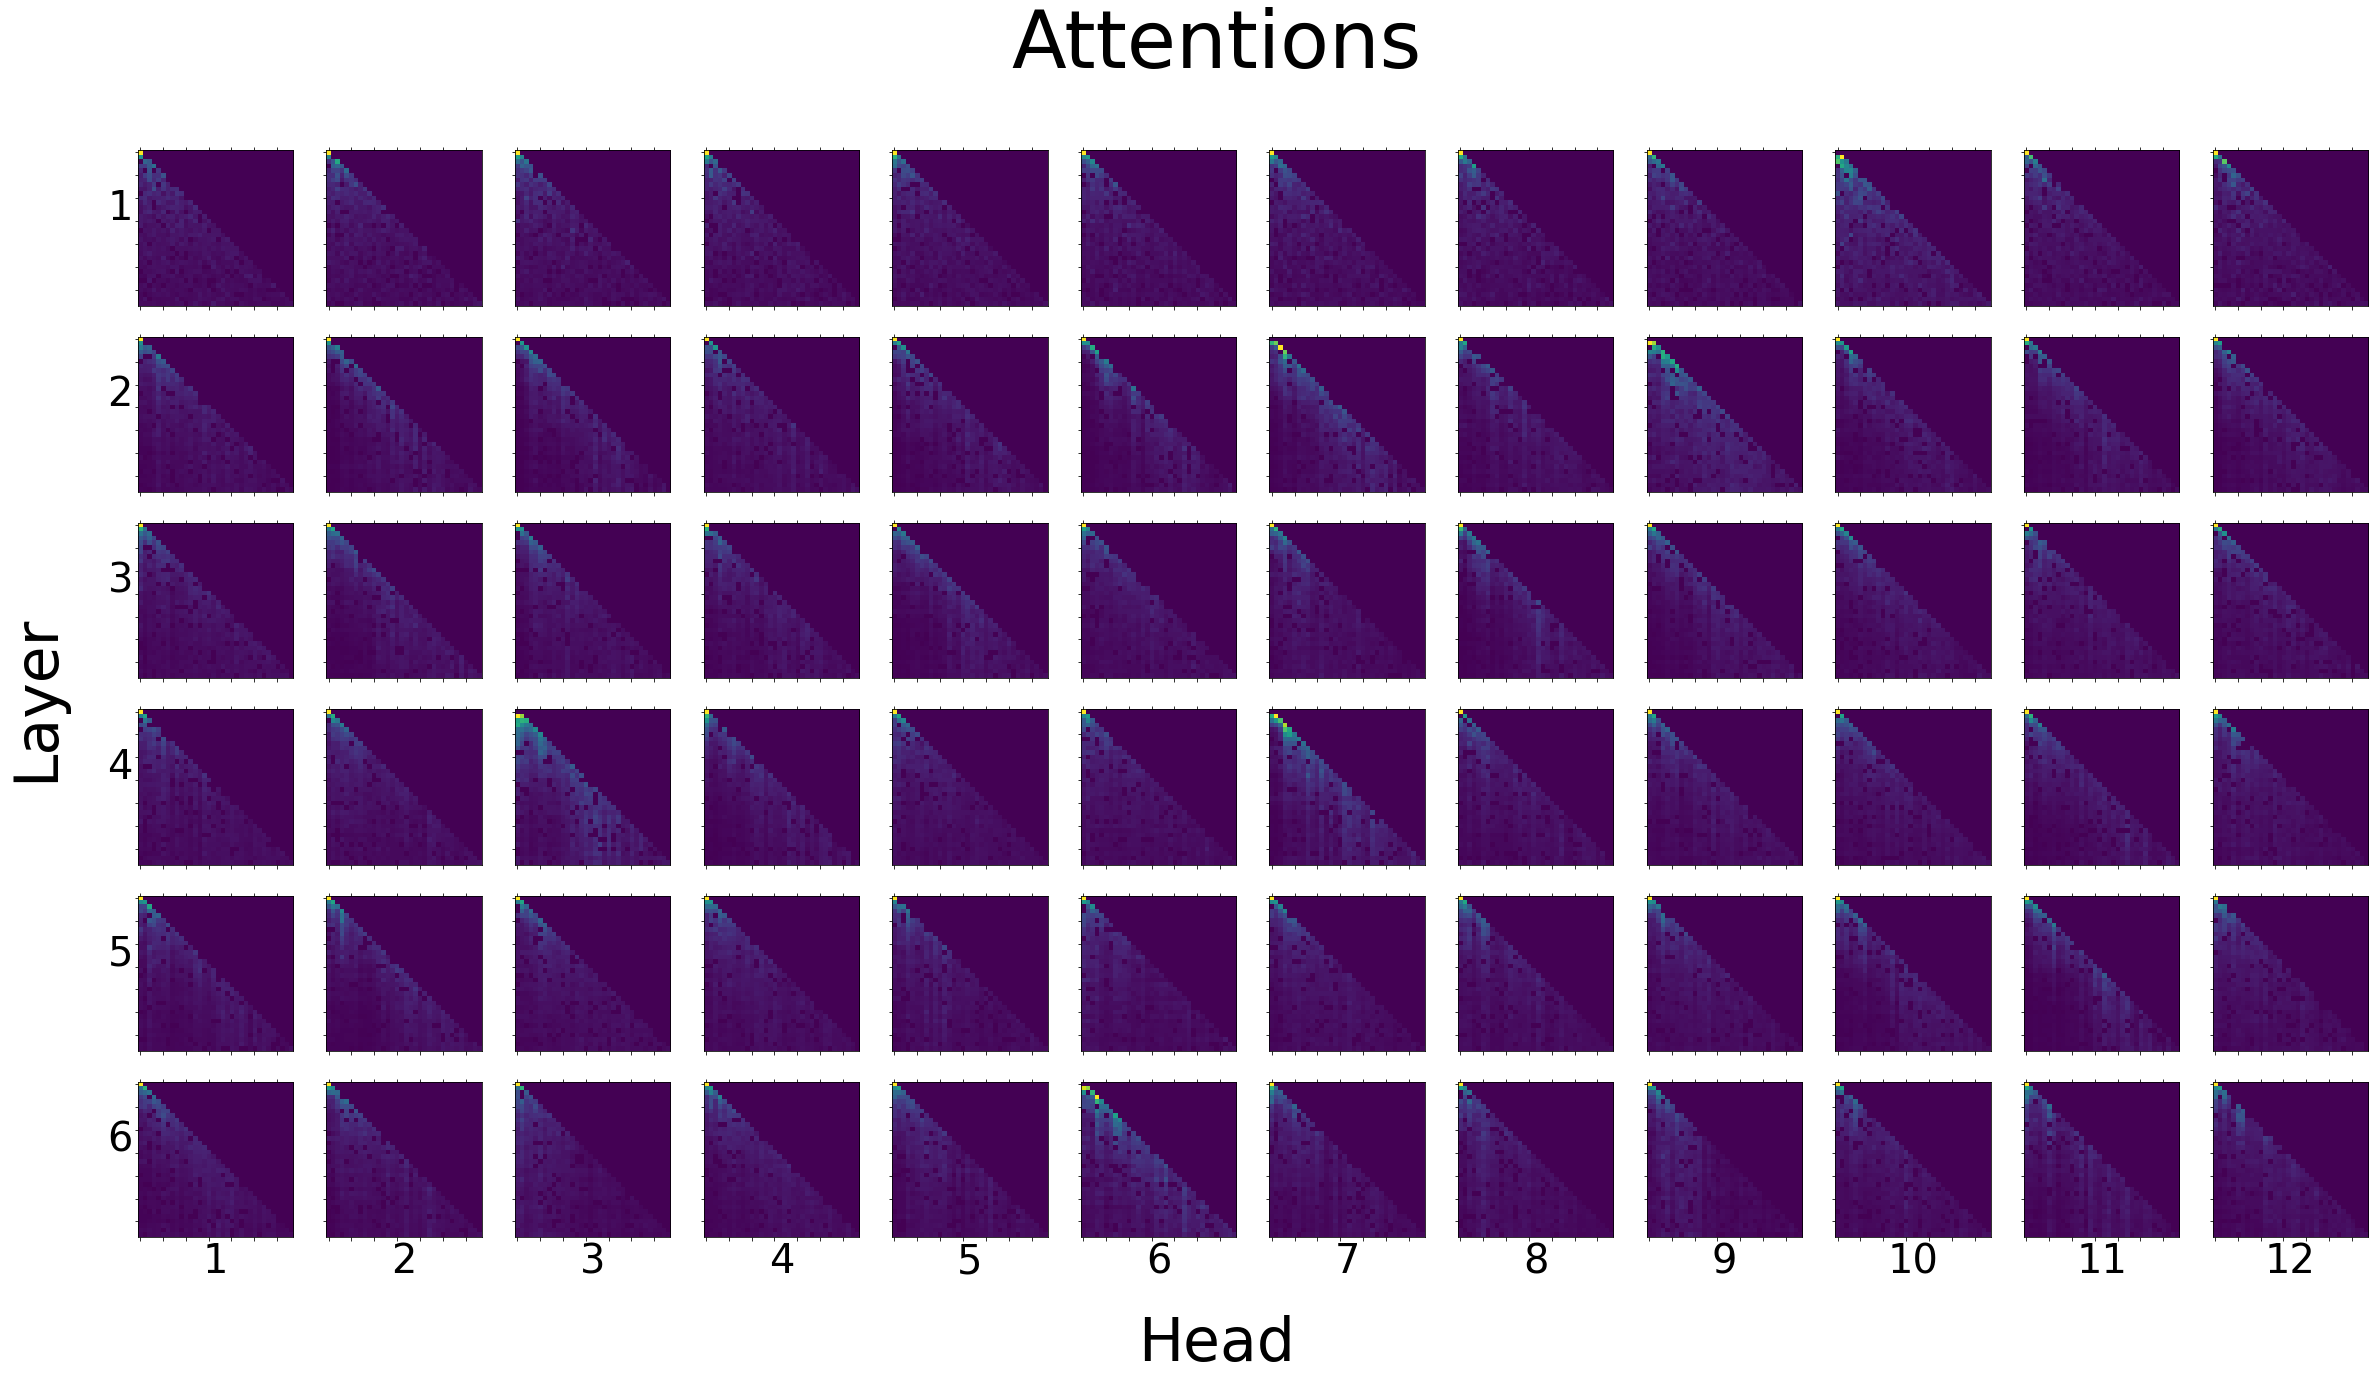

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_all_attentions(tokens, attns)

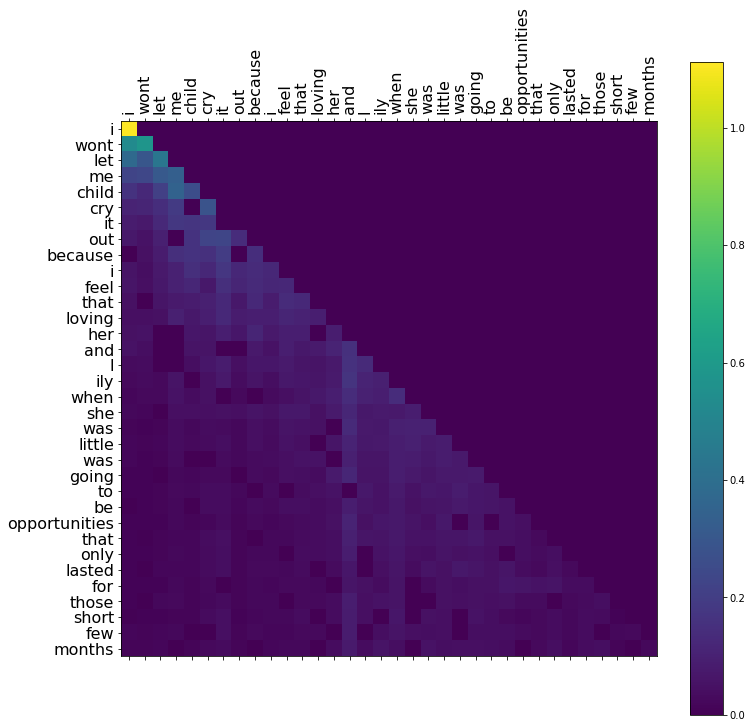

In [ ]:
# attns[i][j] — attention с j-й головы i-го слоя
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

Видно, что, в целом, внимание на всех слоях и головах сильно 
размыто, выделить какие-то конкретные, осмысленные паттерны сложно. Тем не менее, можно заметить, что во многих случаях бóльшее внимание уделялось близким (соседним) словам — на таких картах внимания нижний левый угол треугольника и область вокруг него значительно темнее областей около диагонали.

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

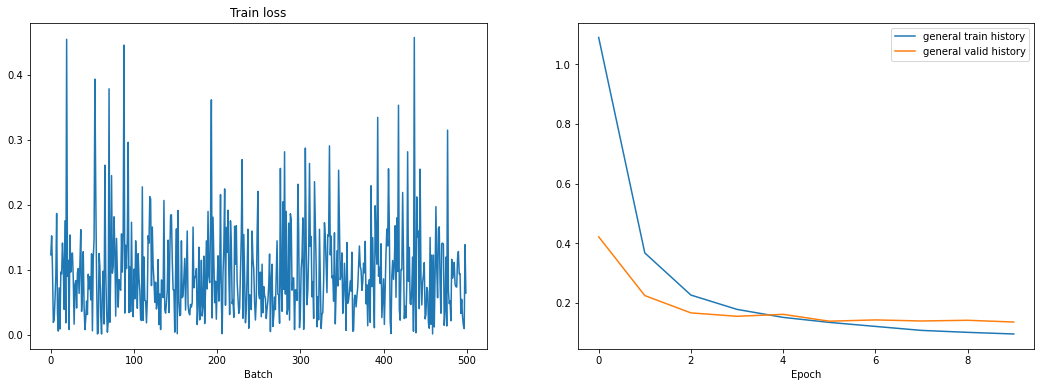

Train Loss: 0.09522775648301467,Valid Loss: 0.13528846455590118,Valid Acc: 0.9424603581428528
Test Acc: 0.920138955116272


In [ ]:
from tqdm.notebook import tqdm

best_valid_loss = float('inf')

num_epochs = 10
train_history = []
valid_history = []

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    history = []
    for batch in tqdm(train_loader):

        optimizer.zero_grad()

        tokens = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        outp = model_1(input_ids=tokens, attention_mask=mask).logits

        loss = criterion(outp, target)
        train_loss += loss.item()
        history.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), 1)
        optimizer.step()

    train_history.append(train_loss / len(train_loader))  

    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            tokens = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            target = batch['target'].to(device)

            outp = model_1(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(outp, target)
            valid_loss += loss.item()

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model_1.state_dict(), 'best-val-model_1.pt')

            valid_acc += torch.sum(torch.argmax(outp, dim=-1) == target) / len(target)
            
    valid_history.append(valid_loss / len(valid_loader))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
 
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')

    ax[1].plot(train_history, label='general train history')        
    ax[1].plot(valid_history, label='general valid history')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.show()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.load_state_dict(torch.load('best-val-model_1.pt'))
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        
        tokens = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        outp = model_1(input_ids=tokens, attention_mask=mask).logits

        test_acc += torch.sum(torch.argmax(outp, dim=-1) == target) / len(target)

print(f"Test Acc: {test_acc / len(test_loader)}")

Есть ли прирост качества или скорости обучения?

По сравнению с первой моделью, здесь переобучение стало проявляться позже — после 5-й эпохи — и не было настолько явным. Кроме того, можно отметить значительный рост качества — величины accuracy на валидационной и и тестовой частях возросли почти на 0.1; лосс на валидационной части стал гораздо меньше, а лосс на тренировочной части при этом почти не изменился. Каких-либо значимых изменений во времени обучения замечено не было.

In [ ]:
model_1.load_state_dict(torch.load('best-val-model_1.pt'))

<All keys matched successfully>

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset['train']['text'][100] # Выбери текст из датасета
print(emotion_dataset['train']['text'][100])
tokens = tokenizer.tokenize(text)
tokens = [x.lstrip('Ġ') for x in tokens]

i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months


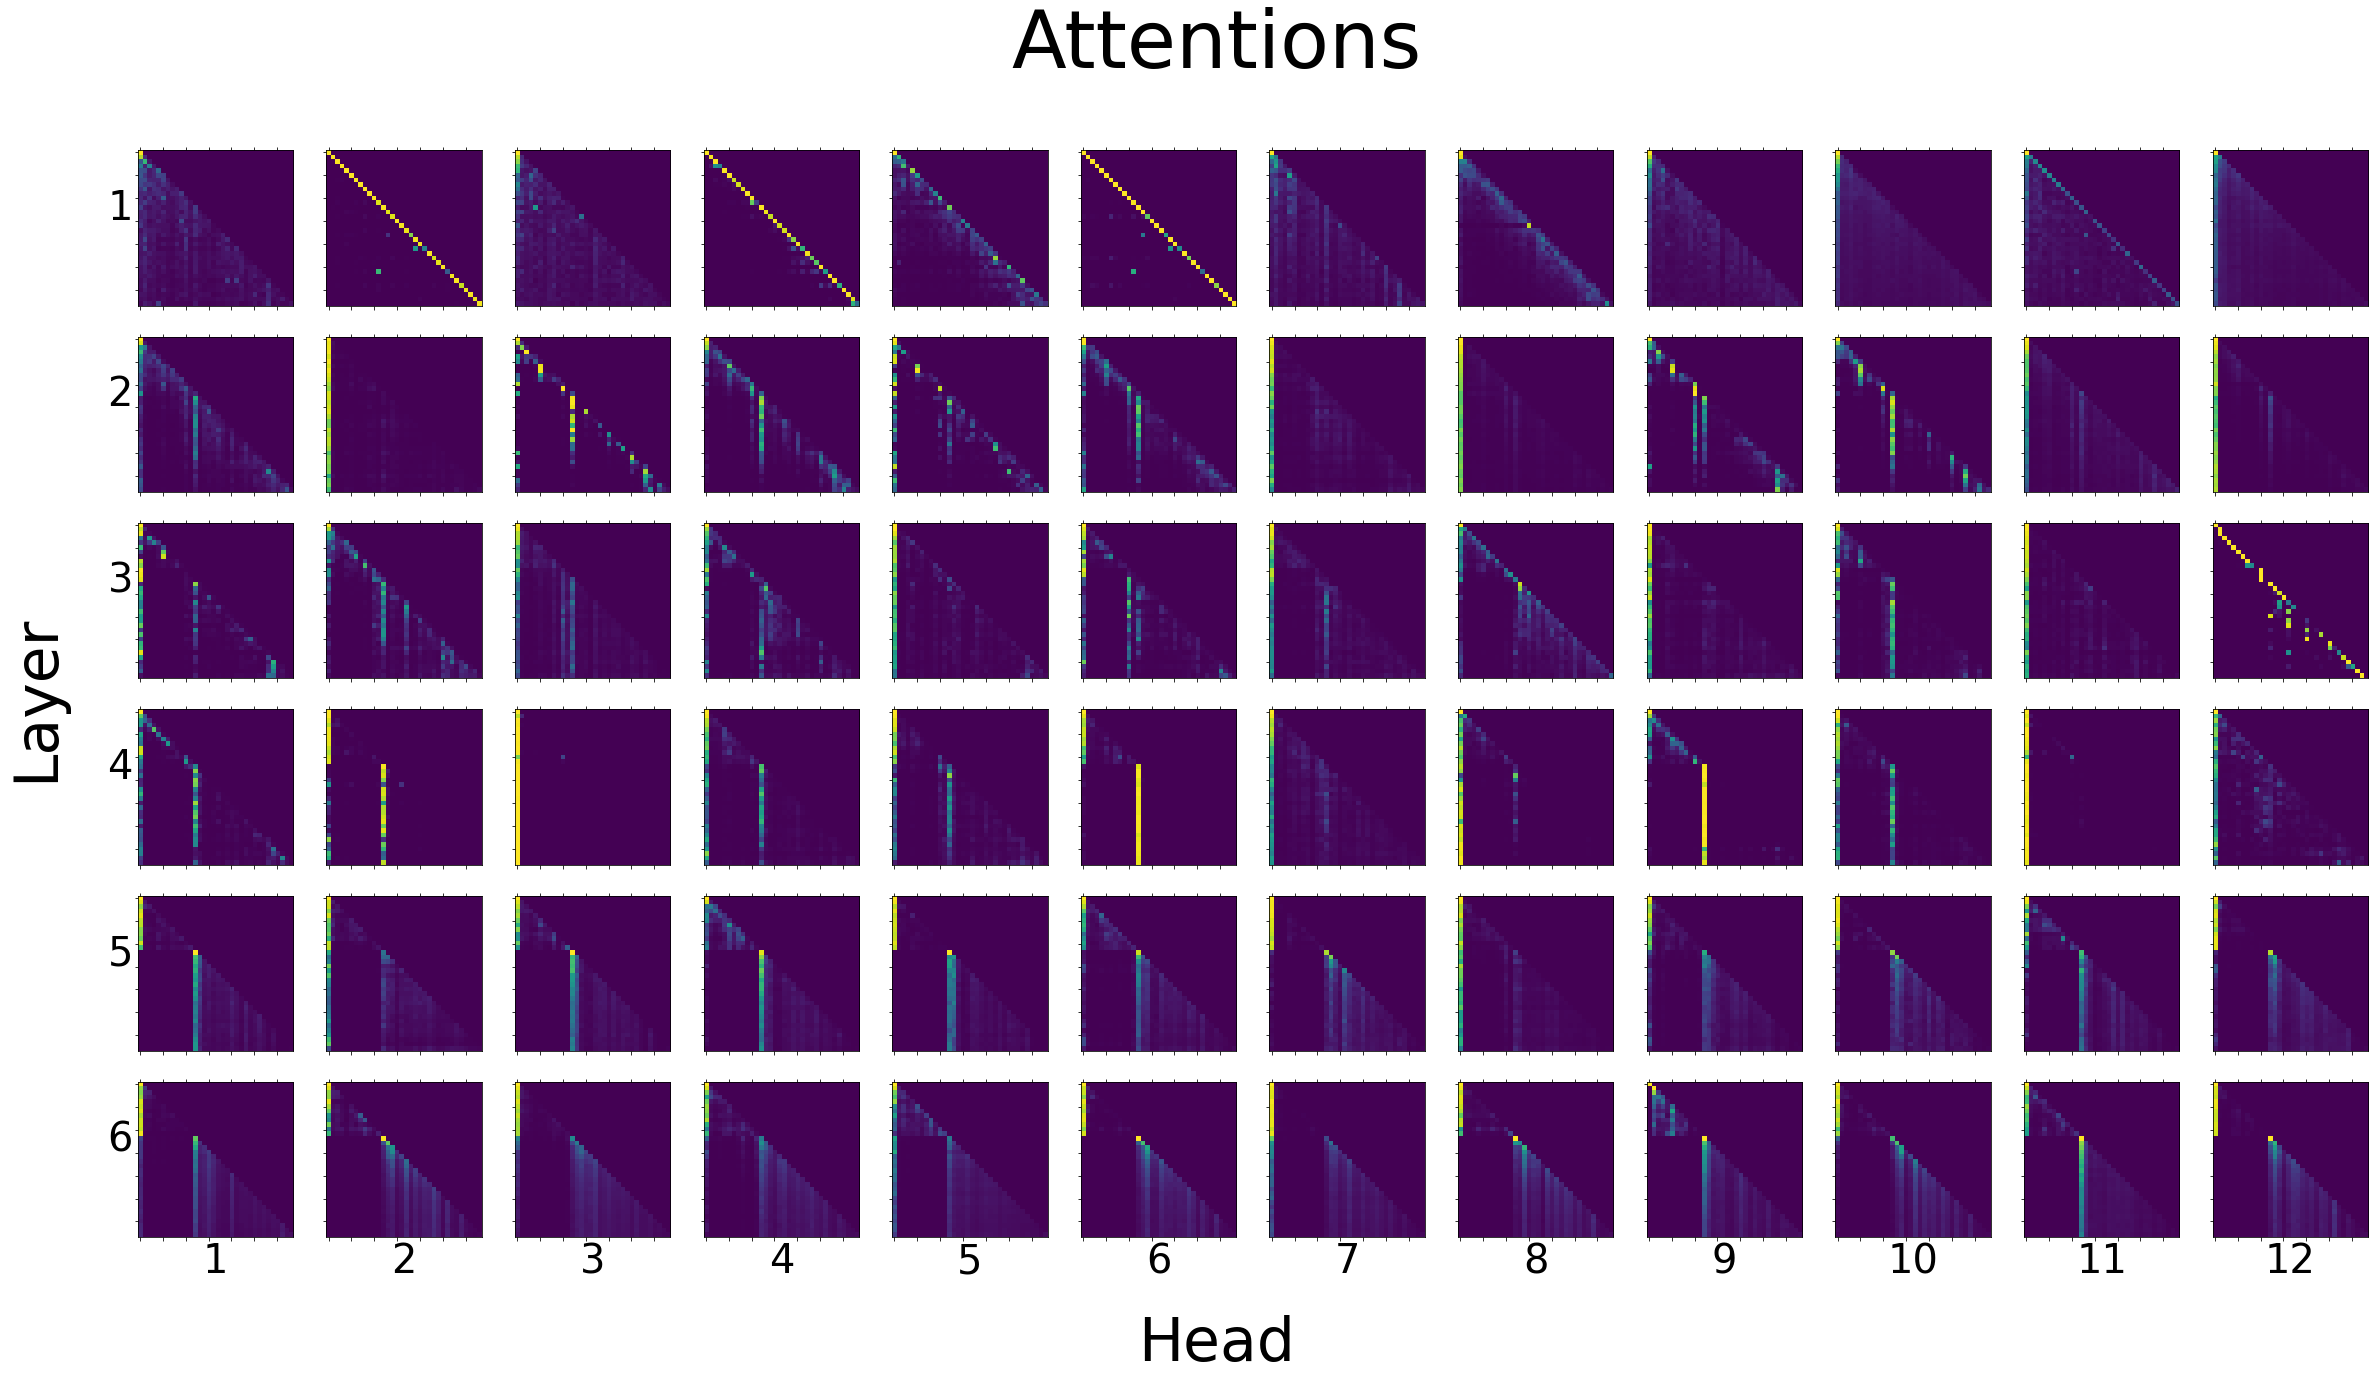

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_all_attentions(tokens, attns)

Теперь карты внимания приняли гораздо более интересный вид. Да, по-прежнему в некоторых слоях есть головы, внимание с которых трудно как-то трактовать, однако на многих изображениях замечается разделение внимания по двум треугольным областям, т.е. предложение как будто разбивается на две части с разным контекстом. При этом для первой части становится важным первое слово предложения, "I", о чём говорит соответствующая ему яркая вертикальная полоска (которую можно заметить на многих картах внимания). Эта же полоска является стороной одного из двух выделяющихся "треугольников внимания" — т.е. все слова данной смысловой части предложения так или иначе обращают внимание на "I".  

Для второй части становится важным какое-то слово, более близкое к середине предложения и, должно быть, сигнализирующее о начале второй смысловой части. Кажется, что это одно и то же слово во всех слоях и головах. Выберем пару примеров, чтобы убедиться в этом и заодним узнать, что это конкретно за слово.

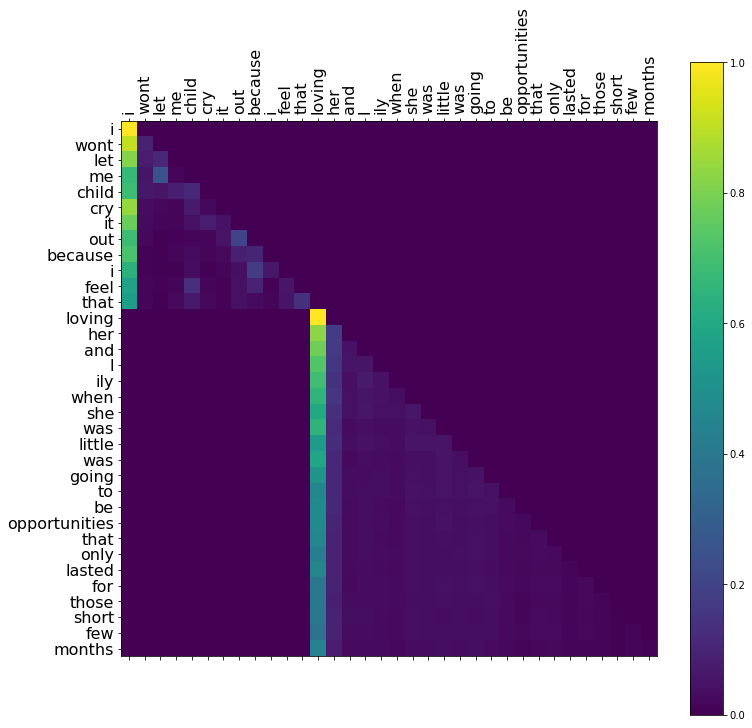

In [ ]:
# attns[i][j] — attention с j-й головы i-го слоя
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][-2])

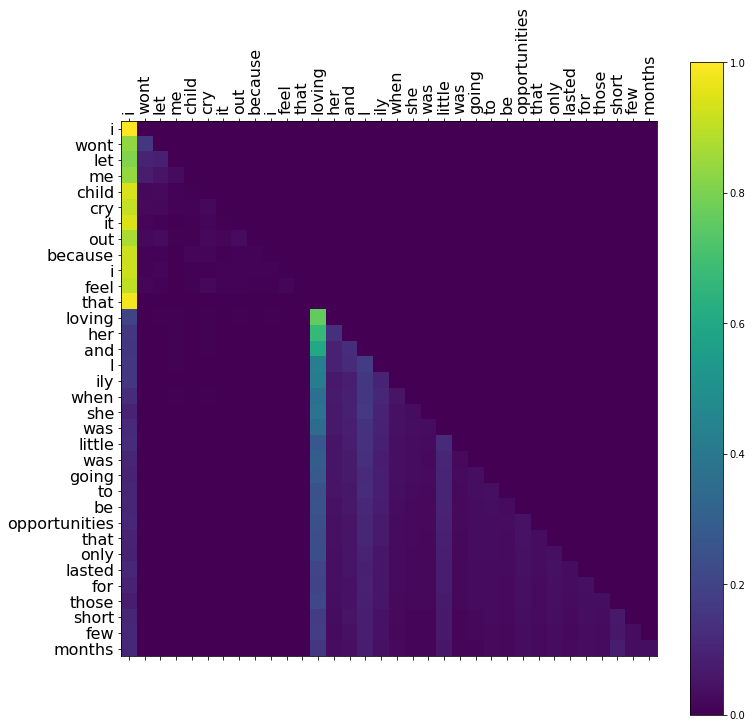

In [ ]:
# attns[i][j] — attention с j-й головы i-го слоя
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

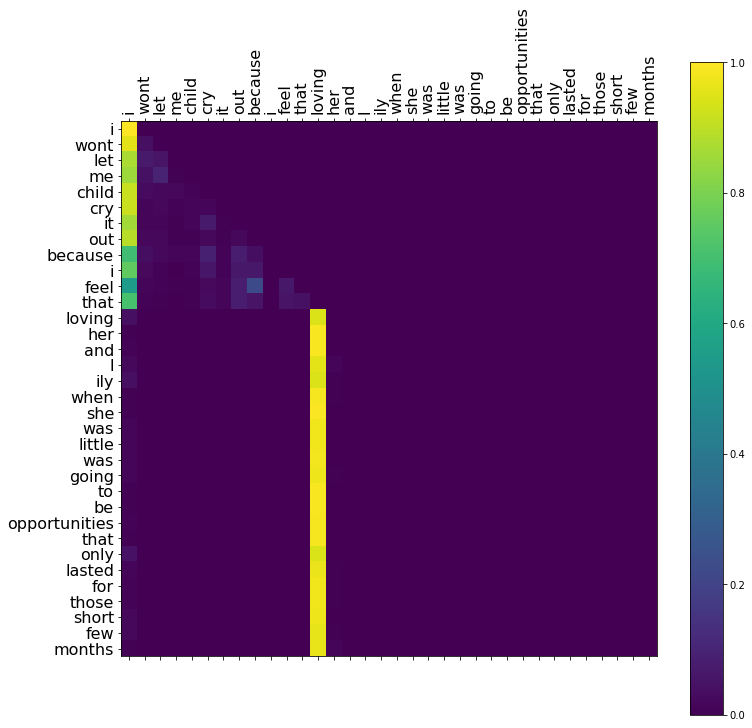

In [ ]:
# attns[i][j] — attention с j-й головы i-го слоя
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[3][5])

На данных трёх примерах видно, что началом второй части служит слово "loving". Примечательно, что предложение действительно можно разделить по контексту на две части, "действие" и "причину", и вторая часть в таком случае будет начинаться с "loving". Что касательно большого внимания, уделяемого почти со всех слов определённой части к "I" или "loving" соответственно, то мне кажется, что оно объясняется ролью данных слов в качестве своеобразных границ контекста. Таким образом, определив, в какой из частей предложения находится слово, модель понимает, на какой контекст обратить внимание.

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

Подводя итог, ещё раз отмечу, что результаты предобученной модели после fine-tuning'а оказались значительно лучше, чем у модели, обученной с нуля. Если разницы во времени обучения и не было, то вот их accuracy и величина валидационного лосса разительно отличались.

Внимание обученной с нуля модели получилось довольно размазанным, без проявления каких-либо явных закономерностей. Помимо этого, карты внимания с разных слоёв и голов почти не отличались между собой.

В картах внимания предобученной модели прослеживалась гораздо более чёткая структура. На первом слое головы обращали большое внимание на слова, ближайшие к рассматриваемому (а иногда и только на само рассматриваемое слово), о чём говорят яркие области около диагонали примерно на половине изображений с данного слоя — хотя, и более размазанные образцы тоже встречаются. В "средних", промежуточных слоях, замечается постепенное разбиение предложения на две смысловые части, при этом большое внимание начинает уделяться словам "I" и "loving", являющимся своеобразными началами этих частей. На последнем же слое почти на всех головах видна явная структура из двух треугольников, иллюстрирующих внимание слов из разных смысловых частей, с по-прежнему заметным акцентом на "I" и "loving" соответственно. Таким образом, внимание, в основном, концентрируется на том, в какую смысловую часть попадает слово, и на контекст слова в рамках этой смысловой части. 

Резюмируя вышесказанное, можно заключить, что предобученная модель показала более высокие результаты по лоссу и accuracy, и при этом её карты внимания отличались более осмысленной структурой, т.е. в рамках данной задачи у fine-tuning'а оказалось явное преимущество над обучением модели с нуля.